# Preprocessing

> Scikit-learn like transformers such as SNV, Continuum removal, ...

In [ ]:
#| default_exp preprocessing

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
from pathlib import Path
from tqdm import tqdm
import re

import fastcore.all as fc
from fastcore.basics import patch

import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

import pywt

In [ ]:
#|eval: false
from lssm.loading import load_ossl, load_mir_kex_spike, load_nir_kex_spike
from lssm.visualization import plot_spectra
from sklearn.pipeline import Pipeline

## Scikit-learn transformers

In [ ]:
#| export
class ToAbsorbance(BaseEstimator, TransformerMixin):
    """Transform Reflectance to Absorbance"""
    def __init__(self, eps=1e-5): self.eps = eps
    def fit(self, X, y=None): return self
    def transform(self, X, y=None): 
        X[X < 0] = 0
        return -np.log10(X + self.eps)

Example: 

In [ ]:
#|eval: false
analytes = 'k.ext_usda.a725_cmolc.kg'
data = load_ossl(analytes, spectra_type='visnir')
X, y, X_names, smp_idx, ds_name, ds_label = data

Reading & selecting data ...


<Figure size 640x480 with 0 Axes>

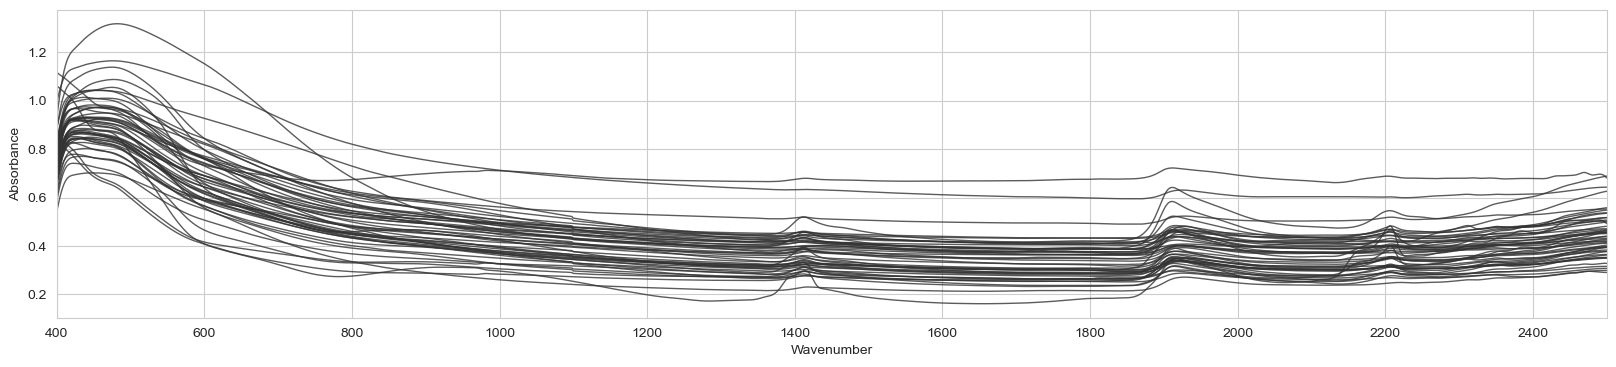

In [ ]:
#|eval: false
plot_spectra(ToAbsorbance().fit_transform(X), X_names)

In [ ]:
#| export
class ContinuumRemoval(BaseEstimator, TransformerMixin):
    """Creates continnum removal custom transformer"""

    def __init__(self, wls):
        fc.store_attr()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        continuum_removed_spectra = np.zeros_like(X)
        
        for i, spectrum in enumerate(tqdm(X)):
            points = np.c_[self.wls, spectrum]
            x, y = points.T 
            # trick to exclude lower part of convex hull 
            augmented = np.concatenate([points, [(x[0], np.max(y)+1), (x[-1], np.max(y)+1)]], axis=0)
            hull = ConvexHull(augmented)
            continuum_points = points[np.sort([v for v in hull.vertices if v < len(points)])]
            continuum_function = interp1d(*continuum_points.T)
            continuum_removed_spectra[i, :] = y / continuum_function(x)
    
        return continuum_removed_spectra

Example:

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44489/44489 [00:15<00:00, 2808.72it/s]


<Figure size 640x480 with 0 Axes>

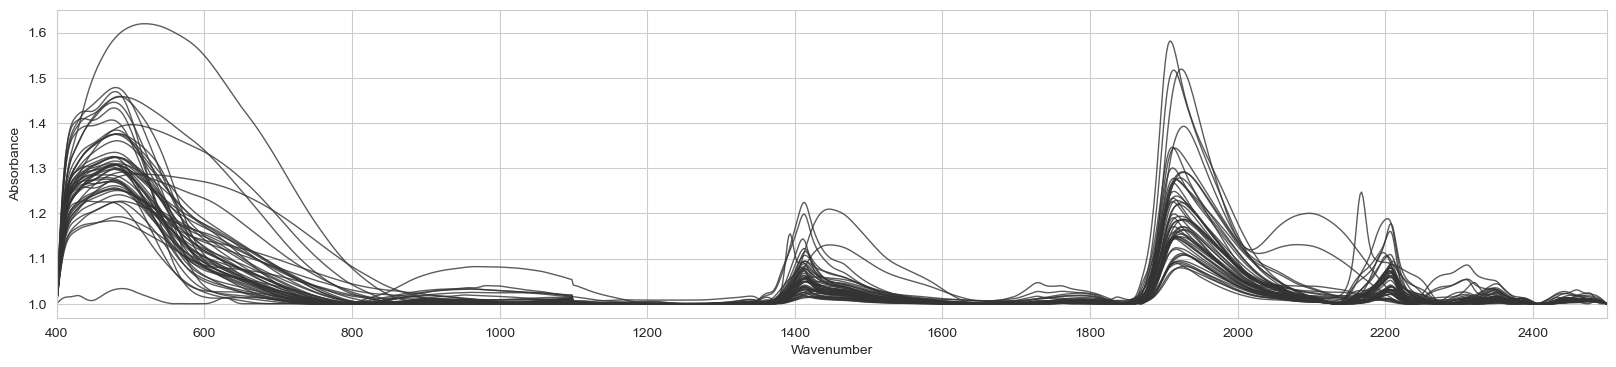

In [ ]:
#|eval: false
pipe = Pipeline([('to_abs', ToAbsorbance()), 
                 ('cr', ContinuumRemoval(X_names))])
plot_spectra(pipe.fit_transform(X), X_names)

In [ ]:
#|export
class SNV(BaseEstimator, TransformerMixin):
    """Creates scikit-learn SNV custom transformer"""
    def fit(self, X, y=None): return self
    def transform(self, X, y=None):
        mean, std = np.mean(X, axis=1).reshape(-1, 1), np.std(X, axis=1).reshape(-1, 1)
        return (X - mean)/std

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44489/44489 [00:15<00:00, 2850.45it/s]


<Figure size 640x480 with 0 Axes>

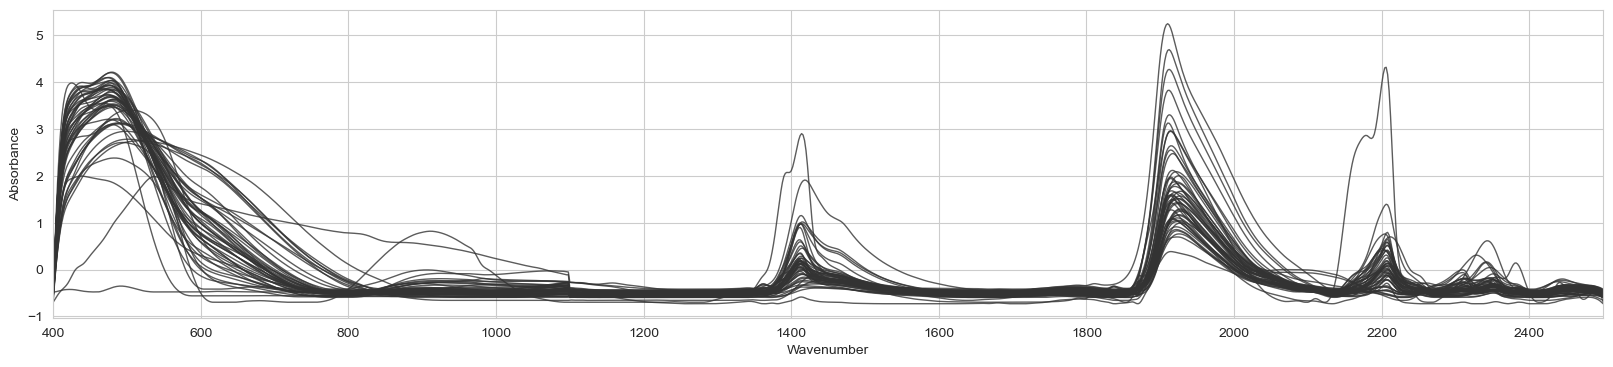

In [ ]:
#|eval: false
pipe = Pipeline([('to_abs', ToAbsorbance()),
                 ('cr', ContinuumRemoval(X_names)),
                 ('snv', SNV())])
plot_spectra(pipe.fit_transform(X), X_names)

In [ ]:
#|export
class Log1p(BaseEstimator, TransformerMixin):
    """Creates scikit-learn `np.log1p` target custom transformer"""
    def fit(self, y, X=None): return self
    def transform(self, y, X=None): return np.log1p(y)

In [ ]:
#|export
class SpikeDiff(BaseEstimator, TransformerMixin):
    """
    Scikit-learn transformer for taking the difference of spiked sample spectra.

    Attributes:
    names (list): List of names to be processed.
    idx (numpy.ndarray): Indices for differences in spectra.
    """
    def __init__(self, names):
        fc.store_attr()
        self.idx = self._get_diffs_idx(self._get_levels_reps())
        
    def _get_levels_reps(self):
        pattern = r'-(\d+)-(\d+)'
        level_rep = [re.search(pattern, name).groups() for name in self.names]

        data = {'index': [], 'level': [], 'replicate': []}
        for i, (level, replicate) in enumerate(level_rep):
            data['index'].append(i)
            data['level'].append(int(level))
            data['replicate'].append(int(replicate))
        
        return pd.DataFrame(data)
    
    def _get_diffs_idx(self, df):
        df_cross = df.merge(df, how='cross')
        return df_cross[df_cross.level_x > df_cross.level_y][['index_x', 'index_y']].values
    
    def fit(self, X, y=None): return self
    
    def transform(self, X):
        return X[self.idx,:][:, 1, :] - X[self.idx,:][:, 0, :]

In [ ]:
src_dir = Path().home() / 'pro/data/k-spiking/mir'
X, wavenumbers, names = load_mir_kex_spike(src_dir)

In [ ]:
mask_smp = np.char.find(names, 'TM') == 0

In [ ]:
#|export 
# SpikeDiff(names[mask_smp]).fit_transform(X[mask_smp,:])

In [ ]:
#|export
class TakeDerivative(BaseEstimator, TransformerMixin):
    """Creates scikit-learn derivation custom transformer

    Args:
        window_length: int, optional
            Specify savgol filter smoothing window length

        polyorder: int, optional
            Specify order of the polynom used to interpolate derived signal

        deriv: int, optional
            Specify derivation degree

    Returns:
        scikit-learn custom transformer
    """
    def __init__(self, window_length=11, polyorder=1, deriv=1):
        self.window_length = window_length
        self.polyorder = polyorder
        self.deriv = deriv

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return savgol_filter(X, self.window_length, self.polyorder, self.deriv)
     

In [ ]:
src_dir = Path().home() / 'pro/data/k-spiking/mir'
X, wavenumbers, names = load_mir_kex_spike(src_dir)

<Figure size 640x480 with 0 Axes>

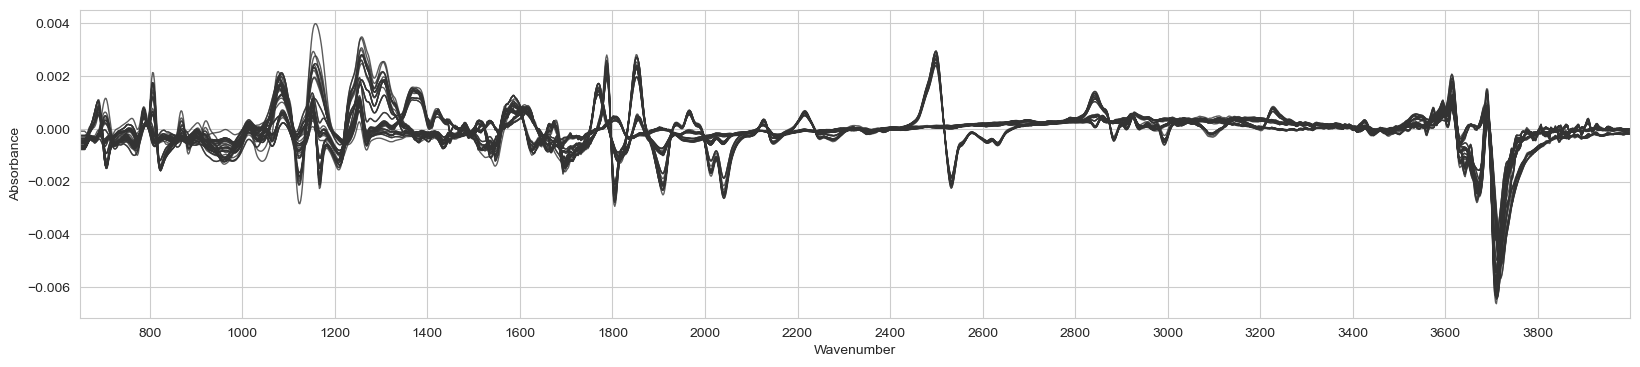

In [ ]:
plot_spectra(TakeDerivative().fit_transform(X), wavenumbers)

In [ ]:
#|export
class MinScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X, y=None):     
        return X - X.min(axis=1, keepdims=True)    

<Figure size 640x480 with 0 Axes>

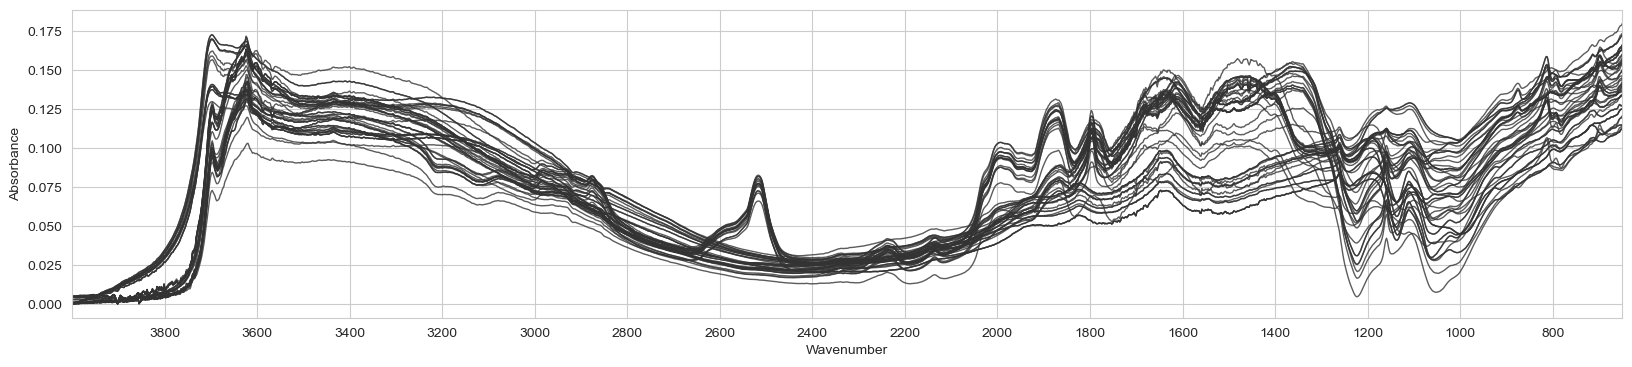

In [ ]:
plot_spectra(MinScaler().fit_transform(X), wavenumbers, ascending=False)

In [ ]:
#|export
class MeanCenter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X, y=None):     
        return X - X.mean(axis=1, keepdims=True)    

<Figure size 640x480 with 0 Axes>

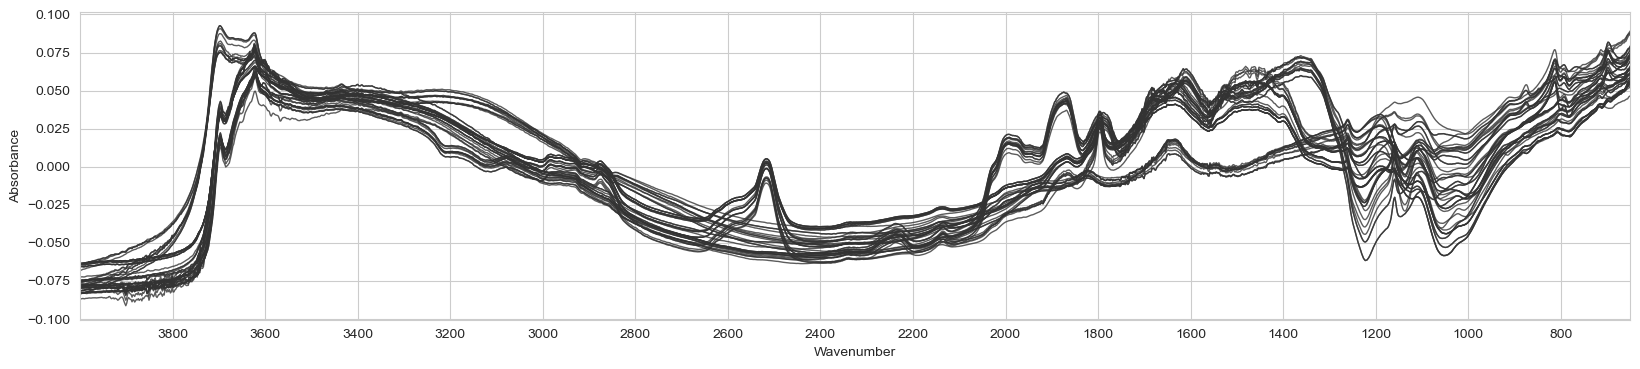

In [ ]:
plot_spectra(MeanCenter().fit_transform(X), wavenumbers, ascending=False)

<Figure size 640x480 with 0 Axes>

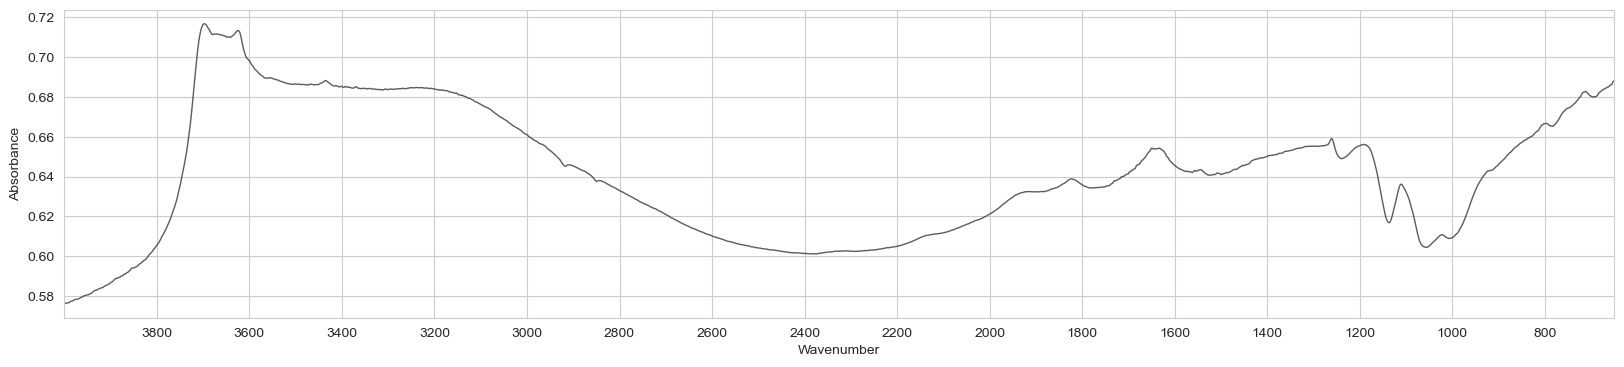

In [ ]:
plot_spectra(X[1], wavenumbers, ascending=False)

In [ ]:
#| export
class BaselineALS(BaseEstimator, TransformerMixin):
    def __init__(self, lam = 1e5, p = 0.01, niter=10):
        fc.store_attr()

    def _baseline_als(self, x):
        L = len(x)
        D = diags([1,-2,1], [0,-1,-2], shape=(L,L-2))
        w = np.ones(L)
        for i in range(self.niter):
            W = diags([w], [0], shape=(L,L))
            Z = W + self.lam * D.dot(D.transpose())
            z = spsolve(Z, w*x)
            w = self.p * (x > z) + (1-self.p) * (x < z)
        return z
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        corrected_spectra = np.zeros_like(X)
        for i, spectrum in enumerate(tqdm(X)):
            baseline = self._baseline_als(spectrum)
            corrected_spectra[i, :] = spectrum - baseline
    
        return corrected_spectra

<Figure size 640x480 with 0 Axes>

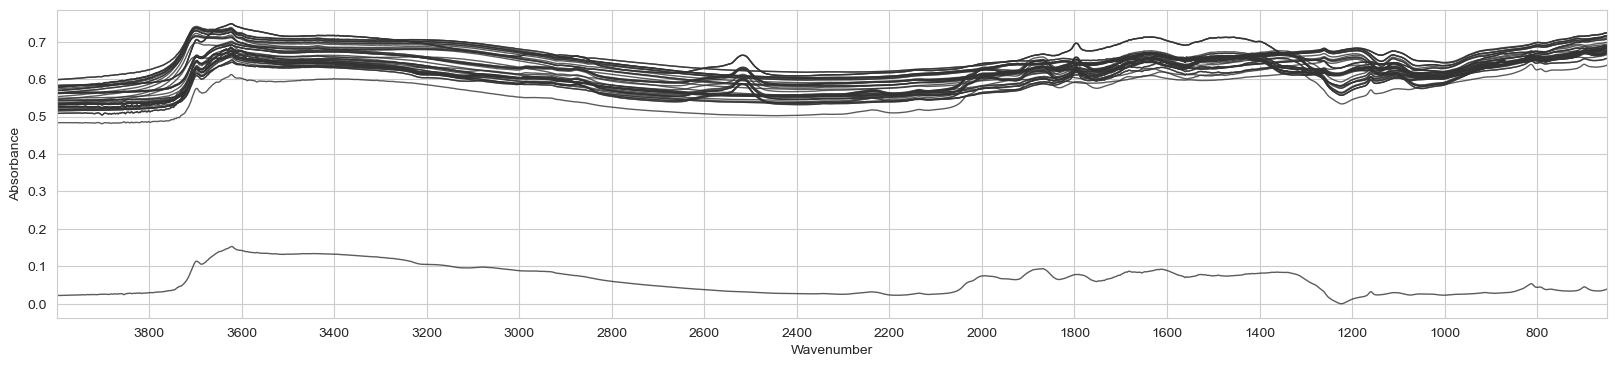

In [ ]:
plot_spectra(X, wavenumbers, ascending=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 82.47it/s]


<Figure size 640x480 with 0 Axes>

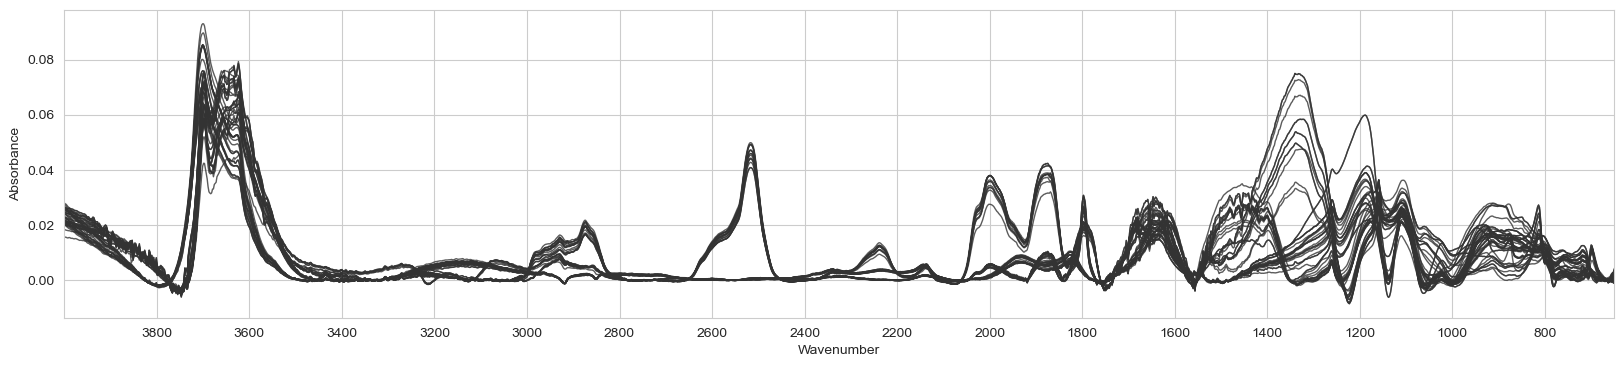

In [ ]:
plot_spectra(BaselineALS().fit_transform(X), wavenumbers, ascending=False)

In [ ]:
#| export
class SpikeMean(BaseEstimator, TransformerMixin):
    def __init__(self, names):
        fc.store_attr()
        self.smp_names = self._get_smp_names()
    
    def _get_smp_names(self):
        return np.unique(np.array([re.sub(r"-\d$", "", name) for name in self.names]))
        
    def fit(self, X, y=None): return self
    
    def transform(self, X):
        means = []
        for name in self.smp_names:
            mask_smp = np.char.find(self.names, name) == 0
            means.append(X[mask_smp].mean(axis=0))
            
        return np.array(means), self.smp_names

In [ ]:
scan_type = 'MIR'

if scan_type == 'MIR':
    src_dir = Path().home() / 'pro/data/k-spiking/mir'
    X, wavenumbers, names = load_mir_kex_spike(src_dir)
else:
    fname = Path().home() / 'pro/data/k-spiking/nir/2023-12-8 _FT-NIR-K-spiked soil.xlsx'
    X, wavenumbers, names = load_nir_kex_spike(fname)

In [ ]:
X_mean, names_mean = SpikeMean(names).fit_transform(X)

print(f'X shape: {X_mean.shape}')
print(f'Sample names: {names_mean}')

X shape: (12, 1738)
Sample names: ['LUI-0' 'LUI-1' 'LUI-2' 'LUI-3' 'SPA1-0' 'SPA1-1' 'SPA1-2' 'SPA1-3'
 'TM4.1-0' 'TM4.1-1' 'TM4.1-2' 'TM4.1-3']


### DWT

In [ ]:
# class SpikeDWT(BaseEstimator, TransformerMixin):
#     def __init__(self, 
#                  names, 
#                  wavenumbers,
#                  top_percentile=1,
#                  levels=range(4, 9),
#                  wavelet_name='db1'):
#         fc.store_attr()
#         self.data = {'level': [], 'smp_name': [],
#                      'wavenumber': [], 'coeff': [],
#                      'resolution': [] # in wavenumbers
#                      }
        
#     X_mean, names_mean

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()